In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import plot_model

2022-11-26 23:56:14.451730: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-26 23:56:14.541903: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-26 23:56:14.545453: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-26 23:56:14.545465: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
df_en = pd.read_csv('/home/madhu/Documents/Datasets/v3/v2/en-te/train.en', header=None, delimiter = "\t")
df_te = pd.read_csv('/home/madhu/Documents/Datasets/v3/v2/en-te/train.te', header=None, delimiter = "\t")

In [3]:
df_en.columns = ['english']
df_te.columns = ['telugu']

In [4]:
print(df_en.iloc[11]['english'])
print(df_te.iloc[11]['telugu'])

Education institutions are closed across the country in the wake of lockdown due to coronavirus outbreak.
కరోనా వైరస్ లాక్ డౌన్ కారణంగా అంతటా విద్యాసంస్థలు మూసివేశారు.


In [5]:
df_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4946035 entries, 0 to 4946034
Data columns (total 1 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   english  object
dtypes: object(1)
memory usage: 37.7+ MB


In [6]:
df_en = df_en[:10000]
df_te = df_te[:10000]




In [7]:
# print(2/0)

In [8]:
df_en.shape

(10000, 1)

In [9]:
ENG_MAX_VOCAB = 10000
TEL_MAX_VOCAB = 10000

eng_vector_layer = tf.keras.layers.TextVectorization(max_tokens=ENG_MAX_VOCAB, output_sequence_length=128)
tel_vector_layer = tf.keras.layers.TextVectorization(max_tokens=TEL_MAX_VOCAB, output_sequence_length=128)

2022-11-26 23:56:26.611298: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 23:56:26.611752: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-26 23:56:26.611833: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-11-26 23:56:26.611903: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-11-26 23:56:26.611965: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [10]:
eng_vector_layer.adapt(df_en['english'])

In [11]:
tel_vector_layer.adapt("<sos> "+df_te['telugu']+" <eos>")

In [12]:
eng_vector_layer.vocabulary_size()

10000

In [13]:
if 'sos' in tel_vector_layer.get_vocabulary():
    print("yes")
else:
    print("no")

yes


In [14]:
tel_vector_layer.get_vocabulary()[:25]

['',
 '[UNK]',
 'sos',
 'eos',
 'ఈ',
 'కూడా',
 'ఆ',
 'మరియు',
 'ఒక',
 'ఇది',
 'ఉంది',
 'రూ',
 'ఆయన',
 'చాలా',
 'కానీ',
 'అని',
 'చేశారు',
 'పోలీసులు',
 'అయితే',
 'నుంచి',
 'లేదు',
 'లో',
 'సినిమా',
 'తన',
 'నేను']

In [19]:
EMBEDDING_DIM = 128

input_layer = tf.keras.layers.Input(shape=(EMBEDDING_DIM,), name="encoder_input")
encoder_embedd_layer = tf.keras.layers.Embedding(input_dim=ENG_MAX_VOCAB, output_dim=EMBEDDING_DIM, mask_zero=True, name="encoder_embedding_layer")(input_layer)
print(encoder_embedd_layer)
encoder_op, h_state, c_state = tf.keras.layers.LSTM(256, return_state=True, dropout=0.4,recurrent_dropout=0.4,name="encoder_lstm")(encoder_embedd_layer)
encoder_states = [h_state, c_state]

KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128), dtype=tf.float32, name=None), name='encoder_embedding_layer/embedding_lookup/Identity_1:0', description="created by layer 'encoder_embedding_layer'")


In [20]:
output_input_layer = tf.keras.layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
decoder_embedd_layer = tf.keras.layers.Embedding(input_dim=ENG_MAX_VOCAB, output_dim=EMBEDDING_DIM, mask_zero=True, name="decoder_embedding_layer")(output_input_layer)
decoder_lstm = tf.keras.layers.LSTM(256, return_sequences=True, return_state=True, dropout=0.4,
                     recurrent_dropout=0.4, name="decoder_lstm")
decoder_output, _, _ = decoder_lstm(decoder_embedd_layer, encoder_states)
decoder_dense = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(len(tel_vector_layer.get_vocabulary()), activation='softmax'))
decoder_outputs = decoder_dense(decoder_output)

In [21]:
model = tf.keras.Model([input_layer,output_input_layer], decoder_outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none'),
#     metrics=['accuracy']
)

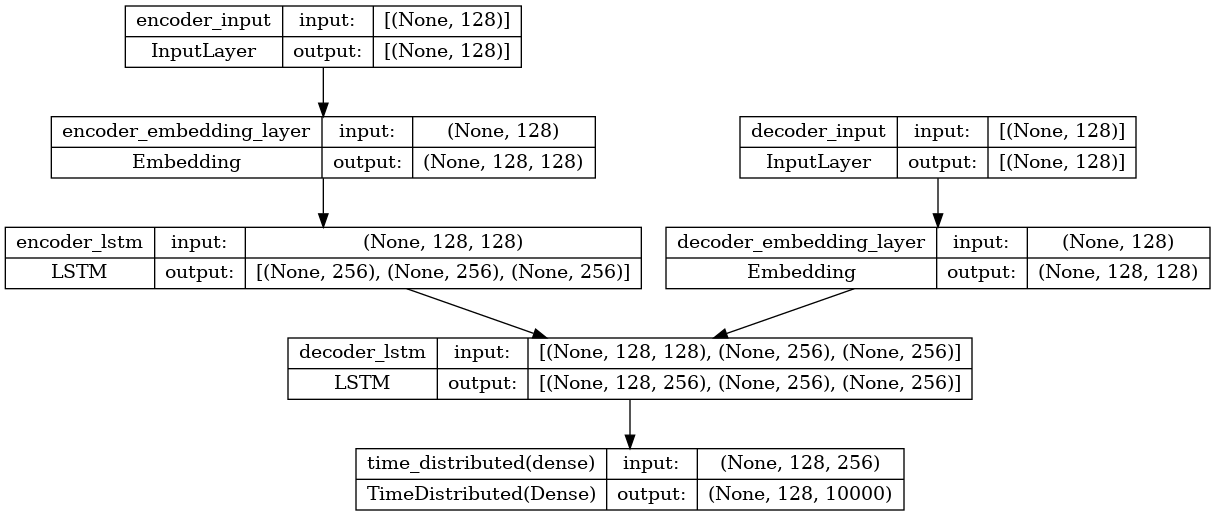

In [22]:
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [32]:
BATCH_SIZE = 128
EPOCHS = 1

tel_start = "<sos> " + df_te
tel_start = tel_vector_layer(tel_start)
tel_start_pad = tf.keras.preprocessing.sequence.pad_sequences(
    tel_start, padding="post"
)
print(tel_start_pad.shape)


tel_end =  df_te + " <eos>"
tel_end = tel_vector_layer(tel_end)

tel_end_pad = tf.keras.preprocessing.sequence.pad_sequences(
    tel_end, padding="post"
)
print(tel_end_pad.shape)

(10000, 128)
(10000, 128)


In [33]:
tel_start_pad[80]

array([   2,  703, 4369,    1,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [34]:
english = eng_vector_layer(df_en)
print(english.shape)

(10000, 128)


In [35]:
result = model.fit(
    x = [english, tel_start],
    y = tel_end,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
#     validation_split=0.2
)

79/79 [==============================] - 209s 3s/step - loss: 0.5756


In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 128)]        0           []                               
                                                                                                  
 decoder_input (InputLayer)     [(None, 128)]        0           []                               
                                                                                                  
 encoder_embedding_layer (Embed  (None, 128, 128)    1280000     ['encoder_input[0][0]']          
 ding)                                                                                            
                                                                                                  
 decoder_embedding_layer (Embed  (None, 128, 128)    1280000     ['decoder_input[0][0]']      

In [ ]:
# https://www.baeldung.com/cs/nlp-encoder-decoder-models
# https://pradeep-dhote9.medium.com/seq2seq-encoder-decoder-lstm-model-1a1c9a43bbac
# https://www.kaggle.com/code/kmkarakaya/part-d-encoder-decoder-with-teacher-forcing